# Relationship between explained variance and time-offset

Supplementary figure that shows the relationship between the explained variance and the time-offset for different brain areas.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.gridspec as gridspec
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func
import VideoAnalysisUtils.plotting_utils as plt_utils

/home/kurgyis/Research/MapVideoAnalysis/python38_venv/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
figfolder = '../figs/supplementary_figs/'
os.makedirs(figfolder, exist_ok=True)

## Load data

In [3]:
r2_new = pickle.load(open('../data/final/r2_embed_cv_timeshift.pkl', 'rb'))
timeshifts = np.arange(-30,32,2, dtype = int)
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

epoch = 'response'
r2_method = 'new'

r2 = []
fr = r2_new['5_0']['avg_fr'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]

delta_r2 = 1.20
fr_threshold = 2.
r2_threshold = 0.01

voxel_size = 300



delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
restriction_inds = np.intersect1d(threshold_inds, delta_inds)

In [4]:
r2_noshift = r2_new['5_0']['%s_r2%s'%(epoch,method_to_string[r2_method])].copy()
is_alm = r2_new['5_0']['is_alm'].copy()
alm_inds = np.where(is_alm)[0]
ccf_labels = r2_new['5_0']['ccf_labels'].copy()
datafolder = '../data/'
#file_name = 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl'
allen_hierarchy_file_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']
df = pd.read_excel(datafolder + allen_hierarchy_file_name, engine='openpyxl', header = None, names = ['id','region','tree'])
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

In [5]:
area_inds = {}
for area in areas:
    inds = func.get_single_area_inds(area, df, ccf_labels, alm_inds)
    area_inds[area] = np.intersect1d(inds, restriction_inds)

### Intial visualization


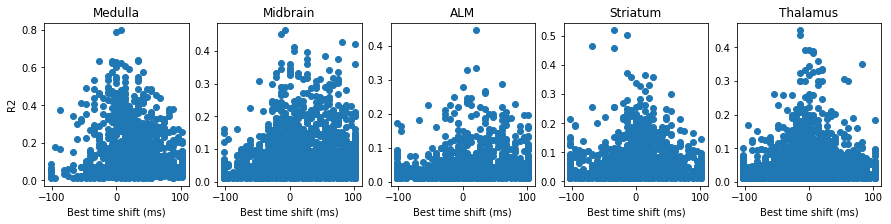

In [6]:
plt.subplots(1,5,figsize = (15,3))
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    plt.plot(best_times[area_inds[area]],r2_noshift[area_inds[area]], 'o')
    plt.title(area)
    plt.xlabel('Best time shift (ms)')
    if i == 0: plt.ylabel('R2')
plt.savefig(figfolder + 'r2_vs_best_timeshift_scatter.png', bbox_inches = 'tight')

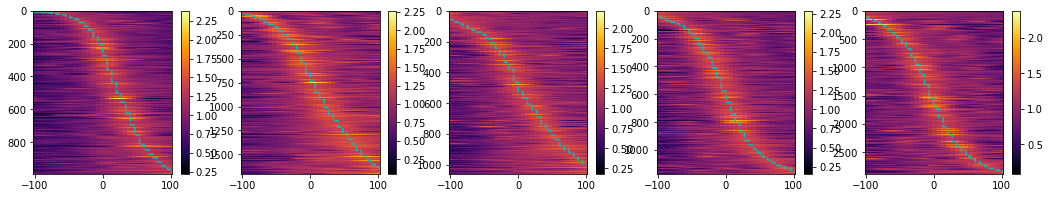

In [7]:
plt.subplots(1,5,figsize = (18,3))
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_sortinds = np.argsort(_best_area_times)

    plt.imshow(_area_shifted_r2[:,_area_sortinds].T / _area_shifted_r2[:,_area_sortinds].T.mean(axis = 1, keepdims = True), aspect = 'auto', cmap = 'inferno', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    plt.plot(_best_area_times[_area_sortinds], np.arange(len(_area_sortinds)), 'c--')
    plt.colorbar()

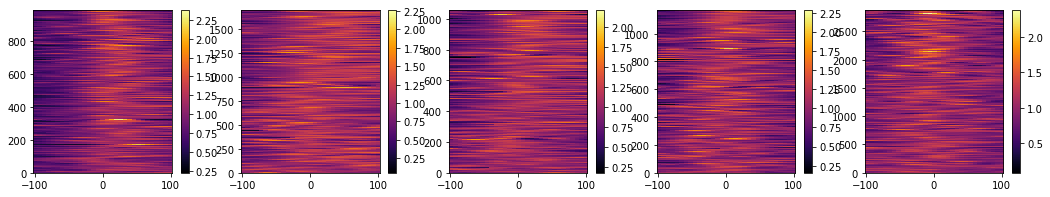

In [8]:
plt.subplots(1,5,figsize = (18,3))
for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)
    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_noshift_r2 = r2_noshift[area_inds[area]]
    _area_sortinds = np.argsort(_area_noshift_r2)

    plt.imshow(_area_shifted_r2[:,_area_sortinds].T / _area_shifted_r2[:,_area_sortinds].T.mean(axis = 1, keepdims = True), 
        aspect = 'auto', cmap = 'inferno', 
        extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, len(_area_sortinds), 0])
    a,b = plt.ylim()
    plt.ylim(b,a)
    plt.colorbar()

## Supplementary figure 

Medulla -0.06410234479496886 0.21769598985642807 992
Midbrain 0.17099369898907005 6.167067346064255e-12 1702
ALM 0.2214698697707558 1.5575372273078273e-12 1059
Striatum 0.15755087447840238 2.988399464295279e-07 1171
Thalamus 0.13216712187064797 5.309009093641582e-12 2881


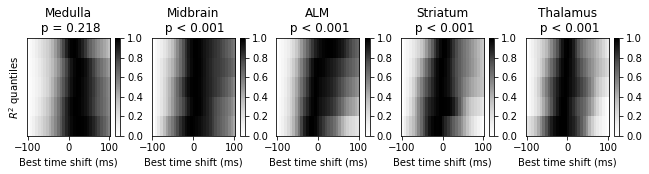

In [10]:
plt.subplots(1,5,figsize = (10.8,1.8))

n_quantiles = 5
n_comparisons = len(areas)

for i, area in enumerate(areas):
    plt.subplot(1,5,i+1)

    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_noshift_r2 = r2_noshift[area_inds[area]]
    _area_sortinds = np.argsort(_area_noshift_r2)

    spearman_corr, spearman_p = stats.spearmanr(_best_area_times, _area_noshift_r2)
    spearman_p *= n_comparisons
    if spearman_p < 0.001: pstring = 'p < 0.001'
    else: pstring = 'p = %.3f'%spearman_p

    print(area, spearman_corr, spearman_p,len(_area_noshift_r2))

    titlestr = '%s\n %s'%(area,pstring)
    plt.title(titlestr)
    quantile_mean_traces = []
    for k in range(n_quantiles):
        quantile_size = len(_area_noshift_r2) // n_quantiles
        start_ind = k * quantile_size
        end_ind = (k+1) * quantile_size
        if k == n_quantiles - 1: end_ind = len(_area_noshift_r2)

        _sorted_shifted_r2 = _area_shifted_r2[:,_area_sortinds] / _area_shifted_r2[:,_area_sortinds].max(axis = 0, keepdims = True)
        _quantile_inds = np.arange(start_ind, end_ind, dtype = int)
        _quantile_mean_trace = _sorted_shifted_r2[:,_quantile_inds].mean(axis = 1)

        quantile_mean_traces.append(_quantile_mean_trace)

    quantile_mean_traces = np.array(quantile_mean_traces)
    normed_quantile_mean_traces = (quantile_mean_traces - quantile_mean_traces.min(axis = 1, keepdims = True)) 
    normed_quantile_mean_traces = normed_quantile_mean_traces / normed_quantile_mean_traces.max(axis = 1, keepdims = True)
    plt.imshow(normed_quantile_mean_traces, aspect = 'auto', cmap = 'Greys', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, n_quantiles, 0])

    a,b = plt.ylim()
    plt.ylim(b,a)
    plt.colorbar()
    plt.yticks([])
    if i == 0: plt.ylabel(r'$R^2$ quantiles')
    plt.xlabel('Best time shift (ms)')
plt.savefig(figfolder + 'r2_quantiles_%d.pdf'%n_quantiles, dpi = 300, bbox_inches = 'tight')

Medulla -0.06410234479496886 0.21769598985642807 992
Midbrain 0.17099369898907005 6.167067346064255e-12 1702
ALM 0.2214698697707558 1.5575372273078273e-12 1059
Striatum 0.15755087447840238 2.988399464295279e-07 1171
Thalamus 0.13216712187064797 5.309009093641582e-12 2881


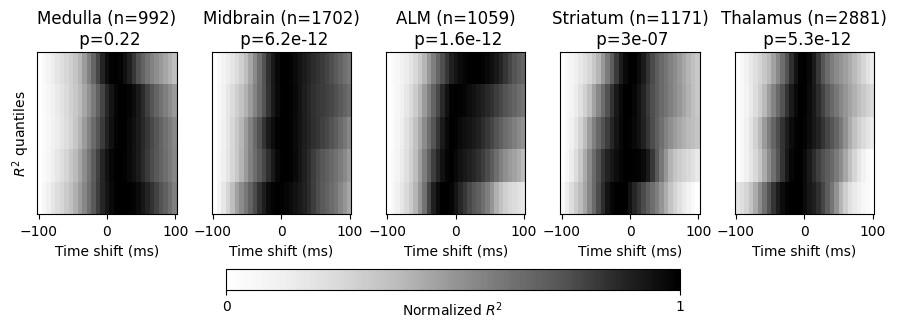

In [9]:
fig,_ = plt.subplots(1,5,figsize = (10.8,2.1))
fig.subplots_adjust(wspace = 0.25, hspace=0.25)

n_quantiles = 5
n_comparisons = len(areas)

for i, area in enumerate(areas):
    ax = plt.subplot(1,5,i+1)
    ax.set_position([ax.get_position().x0,  # Move left
                    ax.get_position().y0+0.25,  # Move down
                    ax.get_position().width,  # Resize width
                    ax.get_position().height])

    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_noshift_r2 = r2_noshift[area_inds[area]]
    _area_sortinds = np.argsort(_area_noshift_r2)

    spearman_corr, spearman_p = stats.spearmanr(_best_area_times, _area_noshift_r2)
    spearman_p *= n_comparisons
    if spearman_p < 0.001: pstring = 'p < 0.001'
    else: pstring = 'p = %.3f'%spearman_p

    print(area, spearman_corr, spearman_p,len(_area_noshift_r2))

    titlestr = '%s (n=%d)\n p=%.2g'%(area,len(_area_noshift_r2),spearman_p)
    ax.set_title(titlestr)
    quantile_mean_traces = []
    for k in range(n_quantiles):
        quantile_size = len(_area_noshift_r2) // n_quantiles
        start_ind = k * quantile_size
        end_ind = (k+1) * quantile_size
        if k == n_quantiles - 1: end_ind = len(_area_noshift_r2)

        _sorted_shifted_r2 = _area_shifted_r2[:,_area_sortinds] / _area_shifted_r2[:,_area_sortinds].max(axis = 0, keepdims = True)
        _quantile_inds = np.arange(start_ind, end_ind, dtype = int)
        _quantile_mean_trace = _sorted_shifted_r2[:,_quantile_inds].mean(axis = 1)

        quantile_mean_traces.append(_quantile_mean_trace)

    quantile_mean_traces = np.array(quantile_mean_traces)
    normed_quantile_mean_traces = (quantile_mean_traces - quantile_mean_traces.min(axis = 1, keepdims = True)) 
    normed_quantile_mean_traces = normed_quantile_mean_traces / normed_quantile_mean_traces.max(axis = 1, keepdims = True)
    im = ax.imshow(normed_quantile_mean_traces, aspect = 'auto', cmap = 'Greys', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, n_quantiles, 0])

    a,b = ax.set_ylim()
    ax.set_ylim(b,a)
    if i == 2:
        colorbar_axis = fig.add_axes([0.3, -0., 0.42, 0.1])
        cbar = fig.colorbar(im, cax = colorbar_axis, orientation='horizontal', fraction = 0.5, pad = 0.01)
        cbar.set_label(r'Normalized $R^2$', labelpad = -10)
        cbar.ax.set_position([cbar.ax.get_position().x0 + 0,  # Move left
                            cbar.ax.get_position().y0 -0.,  # Move down
                            cbar.ax.get_position().width, 
                            cbar.ax.get_position().height])
        cbar.set_ticks([0,1])
    ax.set_yticks([])
    if i == 0: plt.ylabel(r'$R^2$ quantiles')
    ax.set_xlabel('Time shift (ms)')
plt.savefig(figfolder + 'r2_quantiles_%d_v2.jpg'%n_quantiles, dpi = 300, bbox_inches = 'tight')

### Stats

In [12]:
for i, area in enumerate(areas):
    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_noshift_r2 = r2_noshift[area_inds[area]]
    _area_r2_lim = np.median(_area_noshift_r2)#(_area_noshift_r2.min() + _area_noshift_r2.max())/2
    _low_r2_inds = np.where(_area_noshift_r2 < _area_r2_lim)[0]
    _high_r2_inds = np.where(_area_noshift_r2 >= _area_r2_lim)[0]

    pearson_corr, pearson_p = stats.pearsonr(_best_area_times, _area_noshift_r2)
    spearman_corr, spearman_p = stats.spearmanr(_best_area_times, _area_noshift_r2)
    t_stat, p_value = stats.ttest_ind(_best_area_times[_low_r2_inds], _best_area_times[_high_r2_inds], equal_var=False)
    mann_stat, mann_p = stats.mannwhitneyu(_best_area_times[_low_r2_inds], _best_area_times[_high_r2_inds])
    shapiro_stat, shapiro_p = stats.shapiro(_best_area_times)

    print(area)
    print('high %.2f +/- %.2f, low %.2f +/- %.2f'%(
        _best_area_times[_high_r2_inds].mean(), 
        _best_area_times[_high_r2_inds].std() / np.sqrt(len(_high_r2_inds)), 
        _best_area_times[_low_r2_inds].mean(), 
        _best_area_times[_low_r2_inds].std() / np.sqrt(len(_low_r2_inds)) ))
    print('t-test', t_stat, p_value)
    print('mannwhitney', mann_stat, mann_p)
    print('pearson', pearson_corr, pearson_p)
    print('spearman', spearman_corr, spearman_p)
    print('shapiro', shapiro_stat, shapiro_p)
    print('-'*10)



Medulla
high 23.39 +/- 1.59, low 25.09 +/- 1.89
t-test 0.6887643573960539 0.49113764494727497
mannwhitney 128350.0 0.23567594934280167
pearson -0.08872069538882503 0.00516845836980026
spearman -0.06410234479496886 0.043539197971285616
shapiro 0.9824549555778503 1.4888128507806186e-09
----------
Midbrain
high 21.22 +/- 1.54, low 4.95 +/- 1.80
t-test -6.877081716022458 8.622562416465008e-12
mannwhitney 299210.0 5.322317621513948e-10
pearson 0.16458672375444372 8.389921441427785e-12
spearman 0.17099369898907005 1.233413469212851e-12
shapiro 0.9816673994064331 6.088532455983398e-14
----------
ALM
high 16.55 +/- 2.23, low -2.34 +/- 2.51
t-test -5.631938232320208 2.2910940367252522e-08
mannwhitney 112079.0 1.575583213872221e-08
pearson 0.17724972432178734 6.34732322804886e-09
spearman 0.2214698697707558 3.1150744546156547e-13
shapiro 0.9708890914916992 9.673472689108314e-14
----------
Striatum
high 1.76 +/- 1.78, low -7.21 +/- 2.01
t-test -3.3428859760961487 0.0008557738225134231
mannwhitney

### Other variations of the supplementary figure with peak R2 instead of zero-timeshift 

Medulla 0.027570088026513995 1.0 992
Midbrain 0.1866839725728619 4.101672349425589e-14 1702
ALM 0.2146841004927519 8.292776759450836e-12 1059
Striatum 0.12954008046152252 4.3567255831201755e-05 1171
Thalamus 0.09801900855223604 6.762715445224386e-07 2881


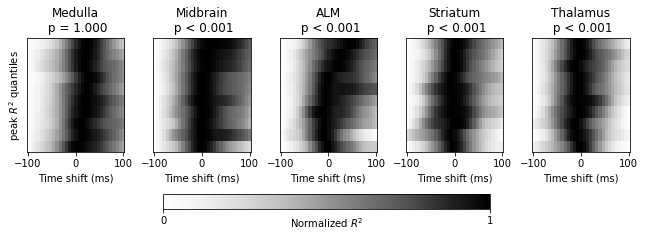

In [23]:
fig,_ = plt.subplots(1,5,figsize = (10.8,2.1))
fig.subplots_adjust(wspace = 0.3)

n_quantiles = 10
n_comparisons = len(areas)

for i, area in enumerate(areas):
    ax = plt.subplot(1,5,i+1)

    _area_shifted_r2 = r2[:,area_inds[area]]
    _best_area_times = 3.4 * timeshifts[np.argmax(_area_shifted_r2, axis = 0)]
    _area_peak_r2 = np.max(r2[:,area_inds[area]], axis = 0)
    _area_sortinds = np.argsort(_area_peak_r2)

    spearman_corr, spearman_p = stats.spearmanr(_best_area_times, _area_peak_r2)
    spearman_p *= n_comparisons
    spearman_p = np.min([spearman_p, 1])
    if spearman_p < 0.001: pstring = 'p < 0.001'
    else: pstring = 'p = %.3f'%spearman_p

    print(area, spearman_corr, spearman_p,len(_area_peak_r2))

    titlestr = '%s\n %s'%(area,pstring)
    ax.set_title(titlestr)
    quantile_mean_traces = []
    for k in range(n_quantiles):
        quantile_size = len(_area_peak_r2) // n_quantiles
        start_ind = k * quantile_size
        end_ind = (k+1) * quantile_size
        if k == n_quantiles - 1: end_ind = len(_area_peak_r2)

        _sorted_shifted_r2 = _area_shifted_r2[:,_area_sortinds] / _area_shifted_r2[:,_area_sortinds].max(axis = 0, keepdims = True)
        _quantile_inds = np.arange(start_ind, end_ind, dtype = int)
        _quantile_mean_trace = _sorted_shifted_r2[:,_quantile_inds].mean(axis = 1)

        quantile_mean_traces.append(_quantile_mean_trace)

    quantile_mean_traces = np.array(quantile_mean_traces)
    normed_quantile_mean_traces = (quantile_mean_traces - quantile_mean_traces.min(axis = 1, keepdims = True)) 
    normed_quantile_mean_traces = normed_quantile_mean_traces / normed_quantile_mean_traces.max(axis = 1, keepdims = True)
    im = ax.imshow(normed_quantile_mean_traces, aspect = 'auto', cmap = 'Greys', extent=[timeshifts[0]*3.4, timeshifts[-1]*3.4, n_quantiles, 0])

    a,b = ax.set_ylim()
    ax.set_ylim(b,a)
    if i == 2:
        colorbar_axis = fig.add_axes([0.3, -0.25, 0.42, 0.1])
        cbar = fig.colorbar(im, cax = colorbar_axis, orientation='horizontal', fraction = 0.5, pad = 0.01)
        cbar.set_label(r'Normalized $R^2$', labelpad = -10)
        cbar.ax.set_position([cbar.ax.get_position().x0 + 0,  # Move left
                            cbar.ax.get_position().y0 + 0,  # Move down
                            cbar.ax.get_position().width, 
                            cbar.ax.get_position().height])
        cbar.set_ticks([0,1])
    ax.set_yticks([])
    if i == 0: plt.ylabel(r'peak $R^2$ quantiles')
    ax.set_xlabel('Time shift (ms)')
#plt.savefig(figfolder + 'r2_quantiles_peakr2_%d_v2.pdf'%n_quantiles, dpi = 300, bbox_inches = 'tight')